In [32]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import missingno as msno

In [33]:
# full_df = pd.read_csv('data/baraj_doluluk.csv')

In [34]:
# full_df.head()

In [35]:
# full_df.rename(columns = {'GENERAL_DAM_RESERVED_WATER':'target','DATE':'date','GENERAL_DAM_OCCUPANCY_RATE':'rate'},inplace=True)

In [36]:
# full_df.head()

In [37]:
# full_df.date = pd.to_datetime(full_df.date)

In [38]:
path = "https://data.ibb.gov.tr/dataset/19c14482-14f2-4803-b4df-4cf4c6c42016/resource/32ecf1d1-9fa6-4f29-bc48-eb997f41a483/download/baraj-doluluk-oranlari.csv"

def prep_data(url=url):
    df = pd.read_csv(path)
    df.rename(columns = {'GENERAL_DAM_RESERVED_WATER':'water','DATE':'date','GENERAL_DAM_OCCUPANCY_RATE':'target'},inplace=True)
    df.date = pd.to_datetime(df.date)
    
    #Get Rid of drastic drop in 2014
    df = df[(df.date>'2015-01-01')].reset_index(drop=True)
    
    return df

In [39]:
df = prep_data()

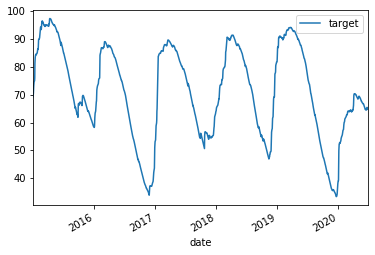

In [40]:
df.plot(x='date',y='target')

In [41]:
def dt_feats(df,date_col='date'):
    
    df['day'] = df[date_col].dt.day
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['week'] = df[date_col].dt.week
    df['dow'] = df[date_col].dt.dayofweek #dayofweek
    df['doy'] = df[date_col].dt.dayofyear #dayofyear
    
    return df

In [42]:
aggs = [['month','dow'],['month','day'],['year','day'],['year','dow']] #['year','month']

def calc_aggs(df,aggs,train_ix):
    
    for grp in aggs:
        grp_name = '_'.join(grp)
        grp_df = df.iloc[train_ix].groupby(grp).target.agg(['mean','std']).reset_index().rename(columns={'mean':f'{grp_name}_mean','std':f'{grp_name}_std'})
        df = df.merge(grp_df,how='left',on=grp)
        df.fillna({f'{grp_name}_mean':grp_df[f'{grp_name}_mean'].median()},inplace=True)
        df.fillna({f'{grp_name}_std':grp_df[f'{grp_name}_std'].median()},inplace=True)
    
    return df

In [43]:
#You can change test/val period size.
period = 30
def form_splits(df,n_folds,period=period):
    indices = []
    for n in range(n_folds):
        val = df[-(n+1)*period-period:-n*period-period]
        val_ix = df[(full_df.date>=val.date.min()) & (df.date<=val.date.max())].index.tolist()
        train_ix = df[:val_ix[0]].index.tolist()
        
        indices.append((train_ix,val_ix))
    
    return indices

In [44]:
def calc_lags(df,use_col,lags):
    
    for lag in lags:
        full_df[f'lag_{lag}'] = full_df[use_col].shift(lag)
    return full_df

In [45]:
full_df = prep_data()
splits = form_splits(full_df,n_folds=2)

del full_df

In [54]:
params = {'n_estimators': 100,
          'objecive':'regression',
          'subsample':0.75,
          #'learning_rate':0.001,
          'max_depth':6,
          #'num_leaves':10000,
          'metric':'mape'
          }

### Time Series Cross Val

In [55]:
pred_df = pd.DataFrame()
pred_df['target'] = prep_data()['target']
pred_df['pred'] = np.nan

In [56]:
scores = []
for fold,(train_ix,val_ix) in enumerate(splits):
    print(f'\nFold {fold+1} \n=================================')
    print(f'Train Size: {len(train_ix)}',f'Val Size: {len(val_ix)}')
    
    full_df = prep_data()
    full_df['known'] = full_df.target
    
    full_df = dt_feats(full_df)
    
    #TODO calc lags
    full_df.known.iloc[val_ix] = np.nan
    full_df = calc_lags(full_df,use_col='known',lags=[120,150,360,720])
    
    full_df = dt_feats(full_df)
    #full_df = calc_aggs(full_df,aggs,train_ix)
    
    train_df,val_df = full_df.iloc[train_ix],full_df.iloc[val_ix]
    
    feats = full_df.columns.difference(['date','water','target','known'])
    
    del full_df
    
    train_y,val_y = train_df.target.values,val_df.target.values
    train_X,val_X = train_df[feats],val_df[feats]
    
    #NECESSARY CHECKS
    assert train_X.shape[0] == train_y.shape[0]
    assert val_X.shape[0] == val_y.shape[0]
    assert train_X.shape[1] == val_X.shape[1]
    
    #LGB PREP
    train_dset = lgb.Dataset(train_X,label=train_y)
    valid_dset = lgb.Dataset(val_X,label=val_y)
    
    
    #LGB MODEL
    model = lgb.train(params,train_dset,valid_sets=[valid_dset],early_stopping_rounds=10,verbose_eval=10)
    
    print(f'Prediction Fold {fold + 1}')
    preds = model.predict(val_X)
    
    assert preds.shape[0] == val_y.shape[0] 
    
    pred_df.pred.iloc[val_ix] = preds
    
    fold_score = np.sqrt(mean_squared_error(val_y,preds))
    scores.append(fold_score)
    print(f'Fold {fold+1} RMSE: ',fold_score)
    
 
#     MODEL FITTING STAGE (Linear Reg)
#     model = LinearRegression(normalize=True)
#     print(f'Fitting Fold {fold+1} Model...')
#     model.fit(train_X,train_y)
#     print(f'Prediction Fold {fold + 1}')
#     preds = model.predict(val_X)
    
#     assert preds.shape[0] == val_y.shape[0] 
    
#     fold_score = np.sqrt(mean_squared_error(val_y,preds))
#     scores.append(fold_score)
#     print(f'Fold {fold+1} RMSE: ',fold_score)
    
    
    
print(f'\nTime Series CV RMSE:', np.mean(scores))


Fold 1 
Train Size: 1946 Val Size: 30
Training until validation scores don't improve for 10 rounds
[10]	valid_0's mape: 0.0135924
[20]	valid_0's mape: 0.0376238
Early stopping, best iteration is:
[12]	valid_0's mape: 0.0099234
Prediction Fold 1
Fold 1 RMSE:  0.8333833933247152

Fold 2 
Train Size: 1916 Val Size: 30


/home/dorukhan/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/dorukhan/anaconda2/envs/py37/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
[10]	valid_0's mape: 0.045694
Early stopping, best iteration is:
[2]	valid_0's mape: 0.0174715
Prediction Fold 2
Fold 2 RMSE:  1.8700122120121179

Time Series CV RMSE: 1.3516978026684165


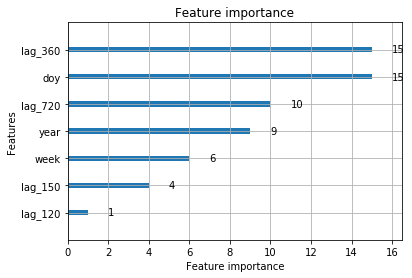

In [57]:
lgb.plot_importance(model)

### Test Prediction

In [58]:
params = {'n_estimators': 100,
          'objecive':'regression',
          'subsample':0.7,
          #'learning_rate':0.01,
          'max_depth':6,
          }

full_df = prep_data()
full_df['known'] = full_df.target

full_df = dt_feats(full_df)

test_ix = list(full_df.tail(period).index)
full_df.known.iloc[test_ix] = np.nan
full_df = calc_lags(full_df,use_col='known',lags=[120,150,360,720])
    
full_df = dt_feats(full_df)
#full_df = calc_aggs(full_df,aggs,train_ix)
    
train_df,test_df = full_df.iloc[:test_ix[0]],full_df.iloc[test_ix]
    
feats = full_df.columns.difference(['date','water','target','known'])
    
train_y,test_y = train_df.target.values,test_df.target.values
train_X,test_X = train_df[feats].values,test_df[feats].values
    
#NECESSARY CHECKS
assert train_X.shape[0] == train_y.shape[0]
assert test_X.shape[0] == test_y.shape[0]
assert train_X.shape[1] == test_X.shape[1]
    
#LGB PREP
train_dset = lgb.Dataset(train_X,label=train_y)
    
    
#LGB MODEL
model = lgb.train(params,train_dset)
    
print(f'Prediction Test')
preds = model.predict(test_X)

pred_df.pred.iloc[test_ix] = preds
    
assert preds.shape[0] == test_y.shape[0] 

/home/dorukhan/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/dorukhan/anaconda2/envs/py37/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Prediction Test


In [59]:
np.sqrt(mean_squared_error(test_y,preds))

1.3396153423653263

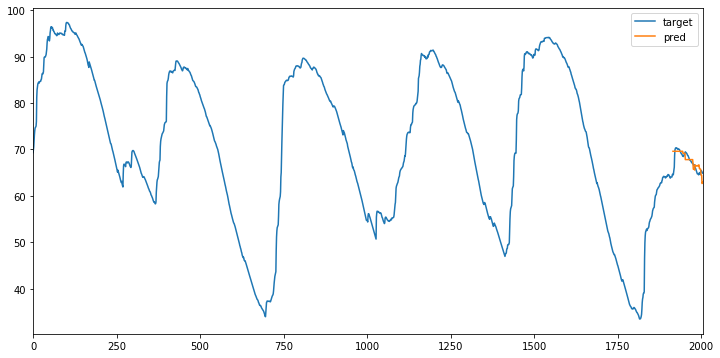

In [60]:
fig, ax = plt.subplots(figsize=(12,6))
pred_df.plot(ax=ax)